<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-предобработка-данных-к-анализу" data-toc-modified-id="Обзор-и-предобработка-данных-к-анализу-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор и предобработка данных к анализу</a></span><ul class="toc-item"><li><span><a href="#Календарь-событий" data-toc-modified-id="Календарь-событий-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Календарь событий</a></span></li><li><span><a href="#Регистрация-новых-пользователей" data-toc-modified-id="Регистрация-новых-пользователей-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Регистрация новых пользователей</a></span></li><li><span><a href="#Действия-новых-пользователей" data-toc-modified-id="Действия-новых-пользователей-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Действия новых пользователей</a></span></li><li><span><a href="#Участники-тестов" data-toc-modified-id="Участники-тестов-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Участники тестов</a></span></li></ul></li><li><span><a href="#Оценка-корректности-проведения-теста" data-toc-modified-id="Оценка-корректности-проведения-теста-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Оценка корректности проведения теста</a></span></li><li><span><a href="#Исследовательский-анализ-выборок" data-toc-modified-id="Исследовательский-анализ-выборок-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ выборок</a></span></li><li><span><a href="#Оценка-результатов-А/В-теста" data-toc-modified-id="Оценка-результатов-А/В-теста-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценка результатов А/В теста</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Анализ А/В теста.

**Описание проекта**

В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Техническое задание:

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Цель исследования**

1. Оценить корректность проведения теста:

   - проверить пересечение тестовой аудитории с конкурирующим тестом,
   - проверить совпадение теста и маркетинговых событий, 
   - выявить при наличии проблемы временных границ теста.
   
2. Проанализировать результаты теста

 **Ход исследования**

 1. Обзор и преобработка данных данных к анализу.
 2. Оценка корректности проведения теста.
 3. Исследовательский анализ выборок.
 4. Оценка результатов А/В теста
 4. Общий вывод.

## Обзор и предобработка данных к анализу

В этом разделе проведем обзор и подготовку данных к анализу:

1. Выгрузим и познакомимся с данными.
2. Найдем и устраним недочеты в данных.

Составим первое представление о данных. Импортируем необходимые для анализа библиотеки.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math as mth

# библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly
import plotly.express as px
#import plotly.offline as pyo
#pyo.init_notebook_mode()

# зададим параметры отображения
pd.set_option('display.max_colwidth', 0)
pd.options.display.max_columns = None

# библиотеки для проверки статистических гипотез
from scipy import stats as st

Познакомимся с данными. Для этого создадим функцию, которая выводит общую информацию о данных, а также проверяет данные на пропуски и дубликаты:

In [3]:
def df_info(df):
    print('Знакомство с данными')
    print('_' * 19, '\n')
    display(df.head(10))
    print()
    print('Сводная информация о данных')
    print('_' * 26, '\n')
    df.info()
    print()
    print("Проверка данных на пропуски и дубликаты")
    print('_' * 35, '\n')
    print()
    print("Доля пропусков:", display(df.isna().mean().round(2)))
    print('_' * 20, '\n')
    print()
    print("Количество дубликатов:", df.duplicated().sum()) 
    print('_' * 22, '\n')

Напишем функцию вывода уникальных значений в столбцах 

In [4]:
def unique_info(df, column):
    for col in df[column]:
        print("Список уникальных значений {}:".format(col))
        print('_' * 32, '\n')
        if df[col].nunique() < 7:
            print(df[col].unique())
        print()

И функцию подсчета количества уникальных значений:

In [5]:
def nunique_info(df, column):   
    print("Количество уникальных пользователей в данных: {}".format(df[column].nunique()))

### Календарь событий

**Загрузим данные и познакомимся с календарем маркетинговых событий на 2020 год**

In [6]:
df_info(marketing_events)

Знакомство с данными
___________________ 



,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11



Сводная информация о данных
__________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Проверка данных на пропуски и дубликаты
___________________________________ 




name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64

Доля пропусков: None
____________________ 


Количество дубликатов: 0
______________________ 



Посмотрим на список уникальных событий в календаре.

In [7]:
unique_info(marketing_events, ['name', 'regions'])

Список уникальных значений name:
________________________________ 


Список уникальных значений regions:
________________________________ 

['EU, N.America' 'EU, CIS, APAC, N.America' 'N.America' 'APAC'
 'EU, CIS, APAC' 'CIS']



Посмотрим период проведения маркетинговых событий. <br>Напишем функцию вывода этой информации.

In [8]:
def date_check(df, column):
    print("Данные представлены за период с", 
          df[column].min(), 
          'по ', 
          df[column].max())

In [9]:
date_check(marketing_events, 'start_dt')

Данные представлены за период с 2020-01-25 по  2020-12-30


In [10]:
date_check(marketing_events, 'finish_dt')

Данные представлены за период с 2020-02-07 по  2021-01-07


Календарь содержит данные о 14 маркетинговых мероприятиях, которые провводились с 25 января 2020 и по 7 января 2021. <br>Данные не содержат пропусков и дубликатов. <br>Но столбцам `start_dt` и `finish_dt` требуется корректировка формата даты и преобразовании в datetime.

Согласно документации к данным:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

Напишем функцию для корректирровки даты в нужный формат:

In [11]:
def data_type_change_and_check(df, column, format_date):
    df[column] = pd.to_datetime(df[column], format=format_date)         
    print("Новый тип данных даты:", df[column].dtypes)

Преобразуем данные о датах в нужный формат:

In [12]:
data_type_change_and_check(marketing_events, 'start_dt', '%Y-%m-%d')

Новый тип данных даты: datetime64[ns]


In [13]:
data_type_change_and_check(marketing_events, 'finish_dt', '%Y-%m-%d')

Новый тип данных даты: datetime64[ns]


### Регистрация новых пользователей

**Загрузим данные и познакомимся с пользователями, зарегистрировавшимися в период с 7 по 21 декабря 2020**

In [14]:
df_info(new_users)

Знакомство с данными
___________________ 



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android



Сводная информация о данных
__________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Проверка данных на пропуски и дубликаты
___________________________________ 




user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64

Доля пропусков: None
____________________ 


Количество дубликатов: 0
______________________ 



Посмотрим на список регионов и девайсов новых пользователей:

In [15]:
unique_info(new_users, ['region', 'device'])

Список уникальных значений region:
________________________________ 

['EU' 'N.America' 'APAC' 'CIS']

Список уникальных значений device:
________________________________ 

['PC' 'Android' 'iPhone' 'Mac']



Количество уникальных пользователей в данных:

In [16]:
nunique_info(new_users, 'user_id')

Количество уникальных пользователей в данных: 61733


Итак, таблица содержит информацию о 61 733 новых уникальных пользователей из четырех регионов. <br>Пропусков, дубликатов в данных не обнаружено. <br>Но столбцу `first_date` требуется корректировка формата даты и преобразовании в datetime.

Согласно документации к данным:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

Преобразуем данные о датах в нужный формат

In [17]:
data_type_change_and_check(new_users, 'first_date', '%Y-%m-%d')

Новый тип данных даты: datetime64[ns]


Посмотрим на соответствие дат регистрации новых пользователей техническому заданию.

In [18]:
date_check(new_users, 'first_date')

Данные представлены за период с 2020-12-07 00:00:00 по  2020-12-23 00:00:00


Поскольку ТЗ установлена дата остановки набора новых пользователей - 21 декабря 2020, значит в данных таблицы `new_users` есть лишние данные за 2 дня с 21 по 23 декабря 2020. Для дальнейшего анализа создадим датасет с корректыми датами, соответствующими ТЗ. 

In [19]:
correct_new_users = new_users.query('first_date <= "2020-12-21"')

In [20]:
date_check(correct_new_users, 'first_date')

Данные представлены за период с 2020-12-07 00:00:00 по  2020-12-21 00:00:00


### Действия новых пользователей

**Загрузим данные и познакомимся с действиями новых пользователей в период с 7 декабря по 4 января 2021**

In [21]:
df_info(final_events)

Знакомство с данными
___________________ 



,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99



Сводная информация о данных
__________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Проверка данных на пропуски и дубликаты
___________________________________ 




user_id       0.00
event_dt      0.00
event_name    0.00
details       0.86
dtype: float64

Доля пропусков: None
____________________ 


Количество дубликатов: 0
______________________ 



Количество уникальных пользователей в данных:

In [22]:
nunique_info(final_events, 'user_id')

Количество уникальных пользователей в данных: 58703


Посмотрим список и дополнительные данные и событиях.

In [23]:
unique_info(final_events, ['event_name', 'details'])

Список уникальных значений event_name:
________________________________ 

['purchase' 'product_cart' 'product_page' 'login']

Список уникальных значений details:
________________________________ 

[ 99.99   9.99   4.99 499.99    nan]



Итак, таблица содержит информацию о действиях 58 703 новых уникальных пользователей. <br>Дуликатов нет, но данные столбца `details` содержат 86% пропусков. <br>Столбцу `event_dt` требуется корректировка формата даты и времени и преобразовании в datetime.

Согласно документации к данным:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase` в этом поле хранится стоимость покупки в долларах.

Преобразуем данные о дате и врмени в нужный формат

In [24]:
data_type_change_and_check(final_events, 'event_dt', '%Y-%m-%dT%H:%M:%S')

Новый тип данных даты: datetime64[ns]


Посмотрим на период действий новых пользователей:

In [25]:
date_check(final_events, 'event_dt')

Данные представлены за период с 2020-12-07 00:00:33 по  2020-12-30 23:36:33


Дата остановки теста по ТЗ задана на 4 января 2021. Стало быть тест был основлен на 5 дней раньше положенного срока. Возможной причиной досрочной остановки могло быть:
   - сильное падение конверсии,
   - технической сбой при сборе логов,
   - пользователи просто перестали совершать события,
   - какие-то непредвиденные обстоятельства.

Попробуем понять причину пропусков в столбце `details`. Посмотрим на количество пропусков по событиям:

In [26]:
(
    final_events[final_events['details'].isna()]
    .groupby('event_name')['user_id']
    .count()
    .sort_values(ascending=False)
)

event_name
login           189552
product_page    125563
product_cart    62462 
Name: user_id, dtype: int64

Посмотрим на общее распределение пользователей по событиям:

In [27]:
final_events['event_name'].value_counts()

login           189552
product_page    125563
purchase        62740 
product_cart    62462 
Name: event_name, dtype: int64

По всей видимости у всех событий, кроме `purchase` просто нет дополнительных деталей события. Пока эти данные не влияют на исследование, оставим так.

### Участники тестов

**Загрузим данные и познакомимся с участниками тестов**

In [28]:
df_info(participants)

Знакомство с данными
___________________ 



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test



Сводная информация о данных
__________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Проверка данных на пропуски и дубликаты
___________________________________ 




user_id    0.0
group      0.0
ab_test    0.0
dtype: float64

Доля пропусков: None
____________________ 


Количество дубликатов: 0
______________________ 



Посмотрим на список названий тестов и группы пользователей:

In [29]:
unique_info(participants, ['group', 'ab_test'])

Список уникальных значений group:
________________________________ 

['A' 'B']

Список уникальных значений ab_test:
________________________________ 

['recommender_system_test' 'interface_eu_test']



Количество уникальных пользователей в данных:

In [30]:
nunique_info(participants, 'user_id')

Количество уникальных пользователей в данных: 16666


По ТЗ мы анализируем участников теста `recommender_system_test`. Посмотрим на их количество:

In [31]:
nunique_info(participants.query('ab_test == "recommender_system_test"'), 'user_id')

Количество уникальных пользователей в данных: 6701


Итак, таблица содержит информацию о 16 666 участников тестов. <br>Пропусков и дуликатов в данных нет. <br>Все столбцы имеют правильный тип данных.

Согласно документации к данным:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**Вывод**

В результате ознакомления с данными, выяснили:

1. все названия столбцов оформлены в 'змеином стиле' и соответсвуют сути данных. Никаких корректировок здесь не требуется.
2. в данных нет дубликатов.
3. информация о дополнительных данных есть только по событию `purchase`, по остальным событиям она, видимо не фиксируется или несущественна, поэтому отсутствует. Таким образом 86% пропусков в столбце `details` не повлияют на результаты анализа и будут оставлены без изменений.
4. все даты в датасетах приведены к нужному формату.

Что интересного было обнаружено на первоначальном этапе:

1. В данных о регистрации новых пользователей есть лишние данные за период, превышающий дату остановки набора согласно ТЗ. Данные `new_users` откоррктированы в соответствии с ТЗ.
2. Выяснили, что тест был остановлен досрочно - 30 декабря 2020, вместо 4 января 2021. 
3. Выяснили, что в данных информация об участников двух тестов. 

Проведем дальнейшую оценку корректности проведения теста и посмотрим не было ли пересечния участников двух тест-групп.

## Оценка корректности проведения теста

В данном разделе будут сделаны следующие шаги:

1. Проверка аудитории теста: пересечение пользователей в двух теста, внутри групп теста, равномерность распределения по тестовым группам и правильность их формирования.
2. Проверка времени проведения теста на совпадение с маркетинговыми и другими активностями.
3. Проверка соответствия данных требованиям всех пунктов технического задания. 

Освежим в памяти первоначальное количество пользователей в нашей тесте:

In [32]:
nunique_info(participants.query('ab_test == "recommender_system_test"'), 'user_id')

Количество уникальных пользователей в данных: 6701


Проверим нет ли одних и тех же пользователей сразу в двух тест-группах. <br>Но, поскольку нам нужно будет исключить "подглядывание" и внутри нашего теста, напишем функцию проверки дублирующихся пользователей:

In [33]:
def check_duplicated_user(df, column, group1, group2, users):
    """
    функция проверяет наличие дублирующихся пользователей в двух группах
    путем создания списка пользователей, присутствующих в обеих группах
    """
    duplicated_user = (pd.Series(list(
        set(df[df[column] == group1][users]) 
        & 
        set(df[df[column] == group2][users])
    ), dtype=pd.StringDtype()))
    return duplicated_user

Создадим список и посмотрим количество таких пользователей если они есть:

In [34]:
duplicated_user_id_in_tests = (check_duplicated_user(participants,
                                                     'ab_test', 
                                                     'recommender_system_test', 
                                                     'interface_eu_test', 
                                                     'user_id'))

In [35]:
print('Итого уникальных дублирующихся пользователей:', duplicated_user_id_in_tests.nunique())

Итого уникальных дублирующихся пользователей: 1602


Таким образом у нас 1602 пользователя, которые  принимали участие одновременно в двух тестах. Посмотрим как распределены доли участников по двум группам нашего теста. Чтобы понять какая доля в каждой группе теста видела комбинированную версию сайта, включающую сразу два изменения согласно тестов. 

In [36]:
(
    participants
    .query('ab_test == "recommender_system_test" and user_id in @duplicated_user_id_in_tests')['group']
    .value_counts(normalize = True)
    .round(3)
)

A    0.575
B    0.425
Name: group, dtype: float64

Разница в 35% говорит нам о том, что влияние теста `interface_eu_test` на группы исследуемого теста `recommender_system_test` будет неравнозначно, что может сказаться на основном результате.

Проверим общее распределение пользователей по группам в рамках нашего теста.

In [37]:
(
    participants
    .query('ab_test == "recommender_system_test"')['group']
    .value_counts(normalize = True)
    .round(3)
)

A    0.571
B    0.429
Name: group, dtype: float64

**Вывод**

* количество участников теста изначально было распределено неравномерно между группами - численность контрольной группы теста на 33% больше численности  группы В. А для успешного проведения теста разница в размерах выборок не должна превышает 1% если иное изначально не оговорено перед началом теста. 
* Но стоит отметить, что распредление долей в выборках без дублирующихся пользователей полностью соответсвует распределению долей с дублями. Загвоздка лищь в том, что мы ничего не знаем о втором тесте. Когда он проходил? Если он проходил параллельно и в теже сроки, что и исследуемый тест, то влияние дублей будет минимальным. А если он начался позже или закончился раньше, то мы имеем нерепрезентативную выборку, так как одни пользователи видели сайт с двумя обновления, а другие- только с одним. Не имея возможности прояснить этот важный момент, предлагаем исключить дублирующихся пользователей. 

Теперь убедимся в том, что не было "подглядования" пользователей между группами исследуемого теста и выборки содержат только уникальных пользователями для каждой группы.

In [38]:
duplicated_user_id_in_group = (check_duplicated_user(participants
                                                     .query('ab_test == "recommender_system_test"'),
                                                     'group', 
                                                     'A', 
                                                     'B', 
                                                     'user_id'))

In [39]:
print('Итого уникальных дублирующихся пользователей:', duplicated_user_id_in_group.nunique())

Итого уникальных дублирующихся пользователей: 0


Отлично, хотя бы пользователи обеих групп теста уникальны. Проблема "подглядывания" пользователей из разных групп внутри теста исключена.

Прежде чем очистить данные от участников второго теста необходимо проверить требование ТЗ о 15% новых пользователей из EU, поэтому для начала объединим все данные кроме календаря по `user_id` и проверим этот пункт. Главная таблица у нас `participants`, поэтому присоединять будем только тех пользователей, что входят в исследуемый тест путем `left` объединения.

In [40]:
full_df = (participants
           .merge(correct_new_users, 
                  on='user_id', 
                  how='left')
           .merge(final_events, 
                  on='user_id', 
                  how='left'))
# выведем общую информацию о новом датасете
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110368 entries, 0 to 110367
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     110368 non-null  object        
 1   group       110368 non-null  object        
 2   ab_test     110368 non-null  object        
 3   first_date  104251 non-null  datetime64[ns]
 4   region      104251 non-null  object        
 5   device      104251 non-null  object        
 6   event_dt    106625 non-null  datetime64[ns]
 7   event_name  106625 non-null  object        
 8   details     15416 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 8.4+ MB


In [41]:
# проверим, что 16 666 участников верно сжойнились
full_df['user_id'].nunique()

16666

Оставим только регион EU

In [42]:
full_df = full_df.query('region == "EU"')

# проверим, что все верно
full_df['region'].unique()

array(['EU'], dtype=object)

Посмотрим на общее количество новых пользователей из EU

In [43]:
print('Общее количество новый пользователей из региона EU:', full_df['user_id'].nunique())

Общее количество новый пользователей из региона EU: 15314


In [44]:
print('15% новых пользователей из региона EU - это', (full_df['user_id'].nunique()*0.15))

15% новых пользователей из региона EU - это 2297.1


И тут мы видим несоответсвие ТЗ: 15% новых пользователей из региона EU - это всего 2297 человек, тогда как ожидаемое количество участников теста - 6000.

Настало время собрать корректных участников теста `recommender_system_test` и исключить из данных дублирующихся участников обоих тестов.

In [45]:
full_df = (full_df
           .query('ab_test == "recommender_system_test" and user_id not in @duplicated_user_id_in_tests')
)
# посмотрим на итоговое количество участников исследуемого теста
full_df['user_id'].nunique()

4749

В данном случае ожидаемое количество участников теста стало значительно меньше ожидаемых 6000 по ТЗ, это была вынужденная, но необходимая мера для качественного анализа.

Еще раз убедимся, что даты соответствуют ТЗ

In [46]:
date_check(full_df, 'first_date')

Данные представлены за период с 2020-12-07 00:00:00 по  2020-12-21 00:00:00


In [47]:
date_check(full_df, 'event_dt')

Данные представлены за период с 2020-12-07 00:16:00 по  2020-12-30 06:42:52


Проверим, не пересекается ли период проведения теста с какими-либо маркетинговыми событиями, что крайне нежелательно, поскольку повышенная активность пользователей, замотивированных какой-либо акцией может существенно исказить результаты теста. Учитывая, что акция могла начаться до 7 декабря, посомтрим также все акции, которые не только начались 7 декабря, но и те, что шли до 30 декабря.

In [48]:
marketing_events[
    (marketing_events['regions'].str.contains('EU')) & 
    ((marketing_events['start_dt'] >= "2020-10-07") |
     (marketing_events['finish_dt'] <= "2020-12-30"))
] 

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10


**Вывод**

Из всей выборки видим, что с 25 декабря началась Рождественская акция, которая безусловно сильно повлияла на покупательскую активность пользователей. Конечно, перед началом теста стоило учитывать, что даты проведения теста приходятся аккурат на одну из пиковых маркетинговых акций. А возможно, что именно "неожиданно" появившаяся повышенная активность клиентов и стала причиной преждевременной остановки теста.  

Данные проанализированы на соответствие ТЗ, поэтому приступим к детальному изучению выборок и проведем исследовательский анализ.

## Исследовательский анализ выборок

На данном этапе проверим:

- Одинаково ли распределено количество событий на пользователя в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Посмотрим на основную информацию о логах:

In [49]:
print("Всего событий в логе:", full_df['event_name'].count())
print('Всего пользователей в логе:', full_df['user_id'].nunique())
print('Среднее количество событий на одного пользователя:', int(len(full_df) / full_df['user_id'].nunique()))
print("Период данных: с", full_df['event_dt'].min(), "по", full_df['event_dt'].max())

Всего событий в логе: 17526
Всего пользователей в логе: 4749
Среднее количество событий на одного пользователя: 4
Период данных: с 2020-12-07 00:16:00 по 2020-12-30 06:42:52


Cоздадим датасет с данными по количеству событий на каждого пользователя.

In [50]:
users_by_groups = (full_df
                   .groupby(['user_id', 'group'])
                   .agg({'event_name':'count'})
                   .rename(columns={'event_name':'event_count'})
                   .reset_index())
users_by_groups

,user_id,group,event_count
0,000ABE35EE11412F,A,0
1,0010A1C096941592,A,12
2,001C05E87D336C59,A,0
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5
...,...,...,...
4744,FF8CF7057415EB29,B,4
4745,FFAE9489C76F352B,A,6
4746,FFB3F647898BA928,B,0
4747,FFC2C5F898D1245B,B,0


Посмотрим одинаково ли распределено количество событий на пользователя в выборках. 

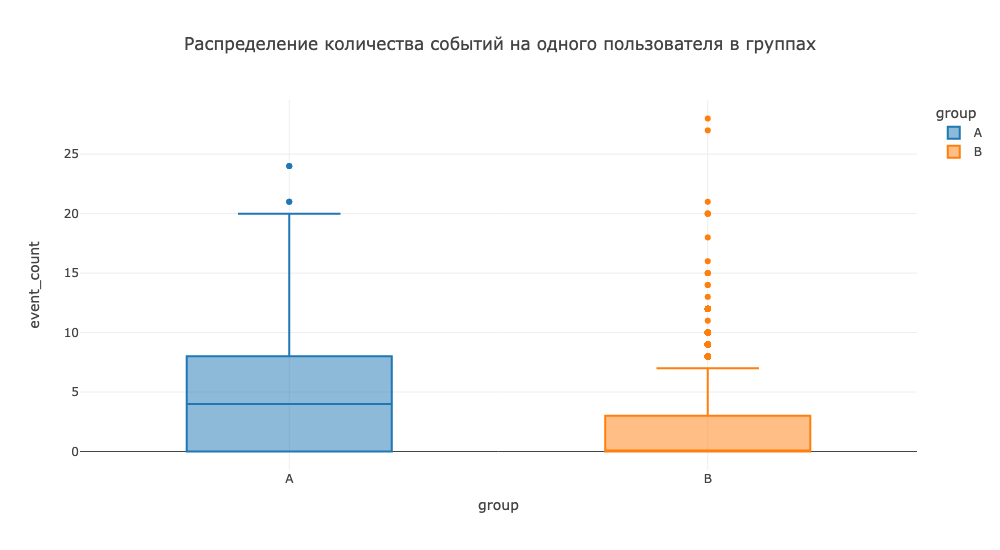

In [51]:
# распределение количества событий на одного пользователя в группе А
fig = px.box(users_by_groups, 
             y='event_count',
             x='group', 
             color='group',
             template='gridon',
             title="Распределение количества событий на одного пользователя в группах",
             labels={'event_name':'Количество событий'})
            
fig.update_layout(width=1000, height=550)

fig.show("png")

Найдем количество пользователей в каждой группе

In [52]:
total_count_users_by_testgroup = users_by_groups['group'].value_counts()
total_count_users_by_testgroup

A    2713
B    2036
Name: group, dtype: int64

Посмотрим на долю пользователей в каждой группе, которые не совершали никаких событий.

In [53]:
(
    users_by_groups[users_by_groups['event_count'] == 0].groupby('group')['user_id'].count() / 
    users_by_groups['group'].value_counts()
).round(2)

group
A    0.29
B    0.68
dtype: float64

Распределение количества событий на одного пользователя в группах разительно отличается:
   * в контрольной группе - А - медианное значение количества событий на одного пользователя равно 4. Но 29% пользователей не совершали никаких действитий,
   * в группе В вообще  - ситуация плачевная - пользователи крайне неактивные - медиана количества событий на пользователя равна 0 и много выбросов в данных, поскольку 68% пользователей не совершали никаких действий на сайте.

**Посмотрим на распределение событий по датам:**

Для этого добавим столбец с датой события в данные.

In [54]:
full_df['event_date'] = pd.to_datetime(full_df['event_dt']).dt.date
data_type_change_and_check(full_df, 'event_date', '%Y-%m-%d')
full_df.head()

Новый тип данных даты: datetime64[ns]


,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


Посмотрим на общее количество событий по дням:

In [55]:
full_df.pivot_table(index='event_date', values='event_name', aggfunc='count')

,event_name
event_date,
2020-12-07,489
2020-12-08,408
2020-12-09,532
2020-12-10,428
2020-12-11,379
2020-12-12,423
2020-12-13,336
2020-12-14,948
2020-12-15,944


Заметен всплеск активности пользователей с 14 по 22 декабря. Вероятнее всего - это закономерный скачок покупательской активности перед Рождеством. Также не стоит забывать о возможном влиянии активности на маркетинговое мероприятие `Christmas&New Year Promo`, даже если оно имело не сильное влияние на покупательский интерес пользователей, что заметно по цифрам. <br>Посмотрим на распределение общего количества каждого события по дням

In [56]:
(
    full_df
    .groupby(['event_date', 'event_name'])['user_id']
    .count()
    .reset_index()
    .sort_values(by='event_date')
    .rename(columns={'user_id':'count'})
)

,event_date,event_name,count
0,2020-12-07,login,217
1,2020-12-07,product_cart,56
2,2020-12-07,product_page,142
3,2020-12-07,purchase,74
4,2020-12-08,login,189
...,...,...,...
90,2020-12-29,product_page,110
88,2020-12-29,login,172
91,2020-12-29,purchase,45
92,2020-12-30,login,1


Построим гистограмму распределения событий за весь период:

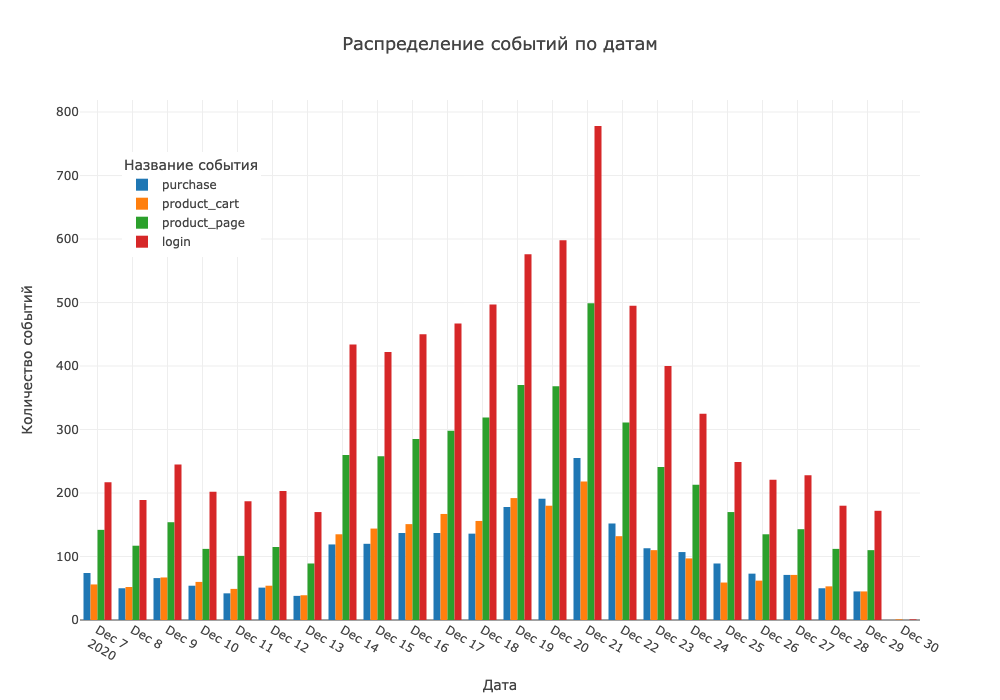

In [57]:
fig = px.histogram(full_df, 
                   x='event_date', 
                   color='event_name',
                   barmode='group',
                   template='gridon',
                   title='Распределение событий по датам')

fig.update_layout(xaxis_title='Дата', 
                  yaxis_title='Количество событий', 
                  autosize=False, 
                  width=1000, 
                  height=700, 
                  legend=dict(x=0.05, y=0.9), 
                  title={'font':dict(size=18)}, 
                  legend_title='Название события'
                 )
fig.update_xaxes(dtick='d1')

fig.show("png")

Да, 14 декабря ативность пользователей в течение дня распределялась равномерно. Но, начиная с 14 декабря активность пользователей резко возрастает и растет до 22 декабря. Возможная причина - массовая закупка подарков за 10 дней до Рождества. <br>Посмотрим как распределились группы теста по датам:

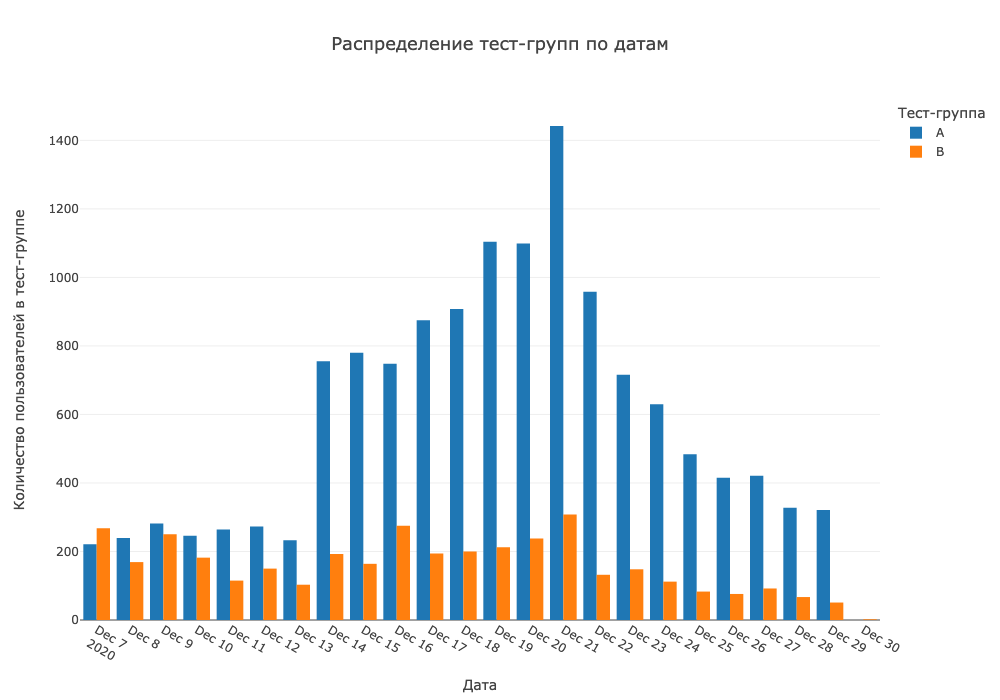

In [58]:
fig = px.histogram(full_df, 
                   x='event_date', 
                   color='group',
                   barmode='group',
                   template='xgridoff',
                   title='Распределение тест-групп по датам'
                  )

fig.update_layout(xaxis_title='Дата', 
                  yaxis_title='Количество пользователей в тест-группе', 
                  autosize=False, 
                  width=1000, 
                  height=700, 
                  title={'font':dict(size=18)}, 
                  legend_title='Тест-группа'
                 )
fig.update_xaxes(dtick='d1')

fig.show("png")

Посмотрим какое количество пользователей ежедневного регистрировалось на сайте с разбивкой по группам. Может здесь кроется причина?

In [59]:
full_df.pivot_table(index='event_date', columns='group', values='user_id', aggfunc='nunique')

group,A,B
event_date,,
2020-12-07,103.0,119.0
2020-12-08,108.0,82.0
2020-12-09,128.0,117.0
2020-12-10,113.0,89.0
2020-12-11,128.0,59.0
2020-12-12,128.0,75.0
2020-12-13,116.0,54.0
2020-12-14,339.0,95.0
2020-12-15,340.0,82.0


График дает нам понять, что в группе В в активный период предрождественской активности было равномерное распределение пользователей по датам. Но стоит отметить, что пользователи группы В в принципе очень неактивны. В группе А 14 декабря произошел бурный всплеск пользовательской активности по причине массового притока новых пользователей: только за один день зарегистрировались 223 новых пользователя. В группе В тоже заметен некоторый всплеск, но несопоставимый с группой А - всего 41 новый пользователь.

Самое время посмотреть как менялась конверсия в воронке в выборках на разных этапах.

1. Определим какие события есть в логах и как часто они встречаются.

In [60]:
(
    full_df
    .pivot_table(index='event_name', 
                 values='user_id', 
                 aggfunc='count')
    .rename(columns={'user_id':'event_count'})
    .sort_values(by='event_count', ascending=False)
    .reset_index()
)

,event_name,event_count
0,login,7906
1,product_page,4922
2,product_cart,2350
3,purchase,2348


2. Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю только тех пользователей, которые хоть раз совершали событие.

In [61]:
count_users_in_event = (
    full_df
    .pivot_table(index='event_name', 
                 values='user_id', 
                 aggfunc='nunique')
    .rename(columns={'user_id':'users_count'})
    .sort_values(by='users_count', ascending=False)
    .reset_index()
)
count_users_in_event['share_all_users'] = (count_users_in_event['users_count'] / 
                                           full_df['user_id'].nunique() * 
                                           100
                                          ).round(2)
count_users_in_event

,event_name,users_count,share_all_users
0,login,2594,54.62
1,product_page,1632,34.37
2,purchase,804,16.93
3,product_cart,773,16.28


Данные показывают, что по общим данным только 16.28% пользователей доходят до успешной оплаты. 

3. Построим воронку событий отдельно по каждой тестируемой группе.

In [62]:
# соберем данные о пользователях по каждой тестируемой группе
count_users_in_event_by_testgroup = (
    full_df
    .pivot_table(index='event_name',
                 columns='group',
                 values='user_id', 
                 aggfunc='nunique')
    .sort_values(by='A', ascending=False)
    .reset_index()
)

# уберем шаг views_tutorial
count_users_in_event_by_testgroup = count_users_in_event_by_testgroup.loc[:3]
count_users_in_event_by_testgroup

group,event_name,A,B
0,login,1939,655
1,product_page,1265,367
2,purchase,613,191
3,product_cart,589,184


Получается, что пользователь может совершить покупку миную какие-то другие этапы. Например, если есть опция купить в один клик. Или еще какие-то другие варианты. Это важный момент, которые указывает нам, что мы имеем дело с простой продуктовой воронкой. Но, нам также важно указать логическую последовательность событий и выстроить события в воронке по ней. Поэтому поменяем этап `purchase` и `product_cart` местами, чтобы покупка была основной целью пользователя.

In [63]:
count_users_in_event_by_testgroup = count_users_in_event_by_testgroup.reindex([0,1,3,2])
count_users_in_event_by_testgroup

group,event_name,A,B
0,login,1939,655
1,product_page,1265,367
3,product_cart,589,184
2,purchase,613,191


Посмотрим на расчет конверсии в шаг и долю пользователей, успешно дошедших до оплаты с первого шага в каждой группе:

In [64]:
def share_initial_and_previous(df, new_column1, new_column2, count_column):
    """
    функция добавляет в датасет столбцы с 
    расчетом конверсии в шаг и 
    расчетом доли пользователей, успешно дошедших до оплаты с первого шага
    """
    # расчет конверсии в шаг
    df[new_column1] = (df[count_column] / df[count_column].shift(periods=1) * 100).round(2)
    # доля пользователей, успешно дошедших до оплаты с первого шага
    df[new_column2] = (df[count_column] / df[count_column].loc[0] * 100).fillna(0).round(2)

In [65]:
share_initial_and_previous(count_users_in_event_by_testgroup, 'share_of_previous_A', 'share_of_initial_A', 'A')
share_initial_and_previous(count_users_in_event_by_testgroup, 'share_of_previous_B', 'share_of_initial_B', 'B')
count_users_in_event_by_testgroup

group,event_name,A,B,share_of_previous_A,share_of_initial_A,share_of_previous_B,share_of_initial_B
0,login,1939,655,NaN,100.00,NaN,100.00
1,product_page,1265,367,65.24,65.24,56.03,56.03
3,product_cart,589,184,46.56,30.38,50.14,28.09
2,purchase,613,191,104.07,31.61,103.80,29.16


Построим составной график воронки событий по группам теста

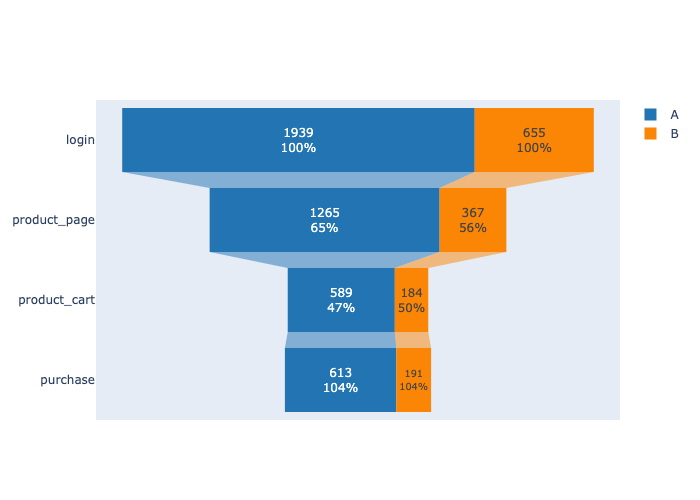

In [66]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = count_users_in_event_by_testgroup['event_name'],
    x = count_users_in_event_by_testgroup['A'],
    textinfo = "value+percent previous", 
    marker = {"color": "#2374b3"}))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = count_users_in_event_by_testgroup['event_name'],
    x = count_users_in_event_by_testgroup['B'],
    textposition = "inside",
    textinfo = "value+percent previous", 
    marker = {"color": "#fb8504"}))

fig.show("png")

**Вывод**

Воронка событий показала, что на этапе `product_page` теряется больше всего пользователей:
   - в группе А - до `product product_cart` не доходят 53.4% пользователей,
   - в группе В - 50% пользователей.
   
Поскольку мы вручную изменили порядок событий на логический, то получилось 104% на шаге успешной покупки. Так как пользователеь может совершить покупку напрямую, минуя все предыдущие шаги и пользуется этим на 4% чаще, чем выстроенной нами последовательностью шагов.

От первого и до последнего шага доходит:
   - в группе А - 31.61% пользователей,
   - в группе В - 29.16% пользователей.

Также стоит отметить, что в группе В значительно больше пользователей отваливается еще на этапе `login`:  на страницу товара переходит на на 9% меньше пользователей, чем в группе А (в относительных цифрах).

**Проверим соответствие последнему пункту ТЗ** - ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
Для этого соберем данные о пользователях по каждой тестируемой группе за 14 дней от начала теста - то есть с 7 по 21 декабря.

In [67]:
count_users_in_event_by_testgroup_14days = (
    full_df.query('first_date < "2020-12-21"')
    .pivot_table(index='event_name',
                 columns='group',
                 values='user_id', 
                 aggfunc='nunique')
    .sort_values(by='A', ascending=False)
    .reset_index()
)

# уберем шаг views_tutorial
count_users_in_event_by_testgroup_14days = count_users_in_event_by_testgroup_14days.loc[:3]
count_users_in_event_by_testgroup_14days

group,event_name,A,B
0,login,1651,593
1,product_page,1072,330
2,purchase,517,167
3,product_cart,514,170


In [68]:
# установим логический порядок шагов
count_users_in_event_by_testgroup_14days = count_users_in_event_by_testgroup_14days.reindex([0,1,3,2])
count_users_in_event_by_testgroup_14days

group,event_name,A,B
0,login,1651,593
1,product_page,1072,330
3,product_cart,514,170
2,purchase,517,167


In [69]:
# расчетаем конверсию в шаг и доли пользователей, успешно дошедших до оплаты с первого шага
share_initial_and_previous(count_users_in_event_by_testgroup_14days, 
                           'share_of_previous_A', 
                           'share_of_initial_A', 
                           'A')
share_initial_and_previous(count_users_in_event_by_testgroup_14days, 
                           'share_of_previous_B', 
                           'share_of_initial_B', 
                           'B')
count_users_in_event_by_testgroup_14days

group,event_name,A,B,share_of_previous_A,share_of_initial_A,share_of_previous_B,share_of_initial_B
0,login,1651,593,NaN,100.00,NaN,100.00
1,product_page,1072,330,64.93,64.93,55.65,55.65
3,product_cart,514,170,47.95,31.13,51.52,28.67
2,purchase,517,167,100.58,31.31,98.24,28.16


Построим составной график воронки событий по группам теста

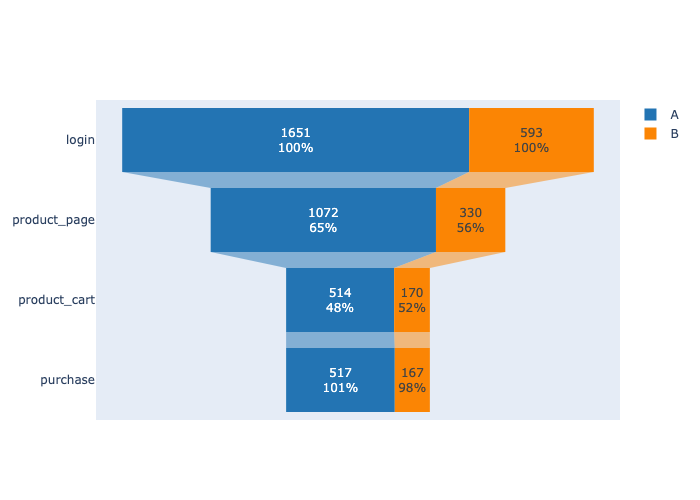

In [70]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = count_users_in_event_by_testgroup_14days['event_name'],
    x = count_users_in_event_by_testgroup_14days['A'],
    textinfo = "value+percent previous", 
    marker = {"color": "#2374b3"}))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = count_users_in_event_by_testgroup_14days['event_name'],
    x = count_users_in_event_by_testgroup_14days['B'],
    textposition = "inside",
    textinfo = "value+percent previous", 
    marker = {"color": "#fb8504"}))

fig.show("png")

**Вывод**

За 14 дней от начала теста воронка событий показывает, что на этапе `product_page` также теряется больше всего пользователей:
   - в группе А - до `product product_cart` не доходят 52% пользователей,
   - в группе В - 48.4% пользователей.
   
От первого и до последнего шага доходит:
   - в группе А - 31.31% пользователей,
   - в группе В - 28.16% пользователей.

В целом, мы видим, что улучшения каждой метрики на 10% по ТЗ тоже не получилось. 

**Критерии успешного A/B тестирования:**


1. *Корректное деление трафика теста*

Пользователи должны распределяться между сегментами равномерно или в соответствии с указанными долями, структура трафика должна быть одинаковой. Например, нельзя считать корректным делением трафика A/B-тест, в котором пользователи группы A — посетители мобильной версии сайта, а пользователи группы B — десктопной.

2. *Необходимо исключить проблему "подглядывания"*


3. *Выборка не должна быть маленькой* - на малых данных не достичь ни значимости, ни точности — слишком велико влияние каждого отдельного наблюдения.


4. *Сроки A/B тестирования должны быть как минимум в течение одного, в идеале двух полных бизнес-циклов*


5. *Исключить аномальную активность пользователей*

Тест проводят в период, когда параллельно не проходят какие-то маркетинговые события, которые могут повлиять на результаты теста. Также тест не проводят в период календарных праздников, которые тоже могут повляить на результат


6. *Предварительно проверить качество деления трафика на группы - А/А тест* 

A/A-тест помогает измерить качество деления, определить доли групп, и подтвердить однородность трафика — отсутствие различия ключевых метрик между группами, которые видят абсолютно одинаковые версии продукта.


## Оценка результатов А/В теста

В этом разделе проведем:
1. Оценку результатов A/В-тестирования.
2. Проверку статистической разницы долей z-критерием.

**Оценка результатов теста:**

Тест подготовлен некорректно:
  - деление трафика между группами неравномерное,
  - была проблема подглядывания между двумя тестами, о возможном влиянии которого на результат нам ничего неизвестно,
  - тест проводился в период маркетингового события,
  - досрочное - на 5 дней раньше положенного срока - окончания теста.
  - не соблюдены требования ТЗ.

Проверим статистическую разницу долей z-критерием:

**Сформулируем гипотезы:**

* Нулевая гипотеза: доли пользователей, совершивших событие в группах НЕ различаются.
* Альтернативная гипотеза: доли пользователей, совершивших событие в группах различаются.

In [71]:
def z_test(group1, group2, alpha):
    '''
    функция проверки гипотезы о равенстве долей пользователей, совершивших событие, в двух группах
    '''
    for i in count_users_in_event_by_testgroup.index:
        # пропорция успехов в группах
        p1 = count_users_in_event_by_testgroup[group1][i] / total_count_users_by_testgroup[group1]
        p2 = count_users_in_event_by_testgroup[group2][i] / total_count_users_by_testgroup[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = (
            (count_users_in_event_by_testgroup[group1][i] + 
             count_users_in_event_by_testgroup[group2][i]) / 
            (total_count_users_by_testgroup[group1] + 
             total_count_users_by_testgroup[group2])
        )
        # разница пропорций в группах
        difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = (difference / mth.sqrt(p_combined * 
                                         (1 - p_combined) * 
                                         (1 / total_count_users_by_testgroup[group1] + 
                                          1 / total_count_users_by_testgroup[group2])
                                        ))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Для события', count_users_in_event_by_testgroup['event_name'][i], 'p-значение = ', p_value)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
        print()

In [72]:
z_test('A', 'B', 0.01)

Для события login p-значение =  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

Для события product_page p-значение =  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

Для события product_cart p-значение =  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

Для события purchase p-значение =  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница



**Вывод**

Мы провели 4 проверки статестических гипотез по каждому событию в отдельности. <br> При уровне значимости alpha=0.01 есть статистически значимая разница между долями пользователей в группах по каждому событию. 

## Общий вывод 

**В процесе анализа данных были проделаны следующие шаги:**

1. Проведен обзор и предварительная подготовка дыннх к анализу:
  - все даты в датасетах приведены к нужному формату
  - проанализированы возможные причины пропусков в данных.
 
 
2. Сделана оценка корректности проведения теста:
  - проведен анализ аудитории теста: пересечение пользователей в двух теста, внутри групп теста, равномерность распределения по тестовым группам и правильность их формирования.
  - проведен анализ времени проведения теста на совпадение с маркетинговыми и другими активностями.
  - проведена общая проверка соответствия данных требованиям всех пунктов технического задания.

3. Проведен исследовательский анализ данных:
  - проанализировано распределение количества событий на пользователя в выборках.
  - проанализировано распределение событий в выборках по дням.
  - проведен анализ конверсии в воронке в выборках на разных этапах.
  - приведены критерии успешного проведения A/B-тестирования.
  
4.  Проведена итоговая оценка результатов A/В-тестирования и проверка статистической разницы долей z-критерием. 

**Что интересного было обнаружено на первоначальном этапе:**

1. В данных о регистрации новых пользователей есть лишние данные за период, превышающий дату остановки набора согласно ТЗ. 
2. Выяснили, что тест был остановлен досрочно - 30 декабря 2020, вместо 4 января 2021. 
3. Выяснили, что в данных информация об участников двух тестов. 
4. Выяснили, что 1602 пользователя принимали участие одновременно в двух тестах. Степень возможного влияния второго теста - неясна.
5. Выяснили, что количество участников теста изначально было распределено неравномерно между группами - разница составляет 35%.
6. "Подглядывания" пользователей внутри теста нет.
7. Установлено несоответствие ТЗ факта о 15% новых пользователей из региона EU.
8. Выявлен факт проведения теста в период маркетингово события `Christmas&New Year Promo`. Это помимо того, что период проведения теста совпадает с предрождественским периодом продаж.
9. Требоване ТЗ об ожидаемом эффекте улучшения метрик не достигнуто.
10. Итоговое корректное количество участников теста ниже ожидаемого: 4 749 вместо 6 000.

**Детальная оценка групп теста показала:**

1. Распределение количества событий на одного пользователя в группах разительно отличается:
   * в контрольной группе - А - медианное значение количества событий на одного пользователя равно 4. Но 29% пользователей не совершали никаких действитий,
   * в группе В вообще  - ситуация плачевная - пользователи крайне неактивные - медиана количества событий на пользователя равна 0 и много выбросов в данных, поскольку 68% пользователей не совершали никаких действий.

2. В группе А 14 декабря произошел бурный всплеск пользовательской активности по причине массового притока новых пользователей: только за один день зарегистрировались 223 новых пользователя. В группе В тоже заметен некоторый всплеск, но несопоставимый с группой А - всего 41 новый пользователь. 

3. Только 16.28% пользователей доходят до успешной оплаты в общем по тесту.

4. Воронка событий показала, что на этапе `product_page` теряется больше всего пользователей:
   - в группе А - до `product product_cart` не доходят 53.4% пользователей,
   - в группе В - 50% пользователей.
   
Поскольку мы вручную изменили порядок событий на логический, то получилось 104% на шаге успешной покупки. Так как пользователеь может совершить покупку напрямую, минуя все предыдущие шаги и пользуется этим на 4% чаще, чем выстроенной нами последовательностью шагов.

От первого и до последнего шага доходит:
   - в группе А - 31.61% пользователей,
   - в группе В - 29.16% пользователей.

Также стоит отметить, что в группе В значительно больше пользователей отваливается еще на этапе `login`:  на страницу товара переходит на на 9% меньше пользователей, чем в группе А (в относительных цифрах).

**Заключение о корректности проведения теста:**

Тест подготовлен и проведен некорректно:

 - деление трафика между группами неравномерное,
 - была проблема подглядывания между двумя тестами, о возможном влиянии которого на результат нам ничего неизвестно,
 - тест проводился в период маркетингового события,
 - досрочное - на 5 дней раньше положенного срока - окончания теста.
 - не соблюдены требования ТЗ.